In [21]:
import numpy as np
import time
import shapely.geometry as shpgeo
FRSQ_OUTPUT_PATH ='../data/output/frsq/raw_venues'

In [7]:
def grid_line(mini, maxi, ngrid=10):
    delta = (maxi-mini)/ngrid
    return [(mini+i*delta, mini+(i+1)*delta) for i in range(ngrid)] 
def grid_area(sw, ne, ngrid=10):
    grid_lat = grid_line(sw[0], ne[0], ngrid)
    grid_lon = grid_line(sw[1], ne[1], ngrid)
#     print grid_lat
#     print grid_lon
    grids = []
    for i in range(ngrid):
        for j in range(ngrid):
            s, n = grid_lat[i]
            w, e = grid_lon[j]
            grids.append(((s,w),(n,e)))
    return grids

In [70]:
import geopandas as gp
%matplotlib inline
dc_poly_gpdf = gp.read_file('data/dc_polygon.geojson')
dc_poly = dc_poly_gpdf.geometry.values[0]
dc_bbox = dc_poly.buffer(0.001).bounds

In [71]:
SW = (dc_bbox[1], dc_bbox[0])
NE = (dc_bbox[3], dc_bbox[2])
dc_bbox, sw, ne

((-77.12076606831646, 38.79063104296462, -76.9083660064054, 38.99685159865696),
 (38.7916303, -77.1197663),
 (38.9958524, -76.909366))

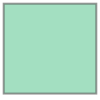

In [72]:
def swne2poly(sw,ne):
    return shpgeo.box(sw[1], sw[0], ne[1], ne[0])

swne2poly(sw, ne)

94
4 194
164
155
154
147
146
145
144
138
137
136
135
134
129
128
127
126
125
124
120
119
118
117
116
115
114
112
111
110
109
108
107
106
105
104
103
102
101
100
99
98
97
96
95
94
93
92
86
85
84
83
82
81
77
3 177
107
98
97
89
88
87
81
80
79
78
77
76
75
74
73
72
71
70
68
67
66
65
2 165
164
163
162
161
160
159
158
157
156
155
154
153
152
151
150
149
148
147
146
145
144
143
142
141
140
139
138
137
136
135
134
133
132
131
130
129
128
127
126
125
124
123
122
121
120
119
118
117
116
115
114
113
112
111
110
109
108
107
106
105
104
103
102
101
100
99
98
97
96
95
94
93
92
91
90
89
88
87
86
85
84
83
82
81
80
79
78
77
76
75
74
73
72
71
70
69
68
67
66
65
64
63
62
61
60
59
58
57
56
55
54
53
52
51
50
49
48
47
46
1 146
145
144
143
142
141
140
139
138
137
136
135
134
133
132
131
130
129
128
127
126
125
124
123
122
121
120
119
118
117
116
115
114
113
112
111
110
109
108
107
106
105
104
103
102
101
100
99
98
97
96
95
94
93
92
91
90
89
88
87
86
85
84
83
82
81
80
79
78
77
76
75
74
73
72
71
70
69
68
67
66
6

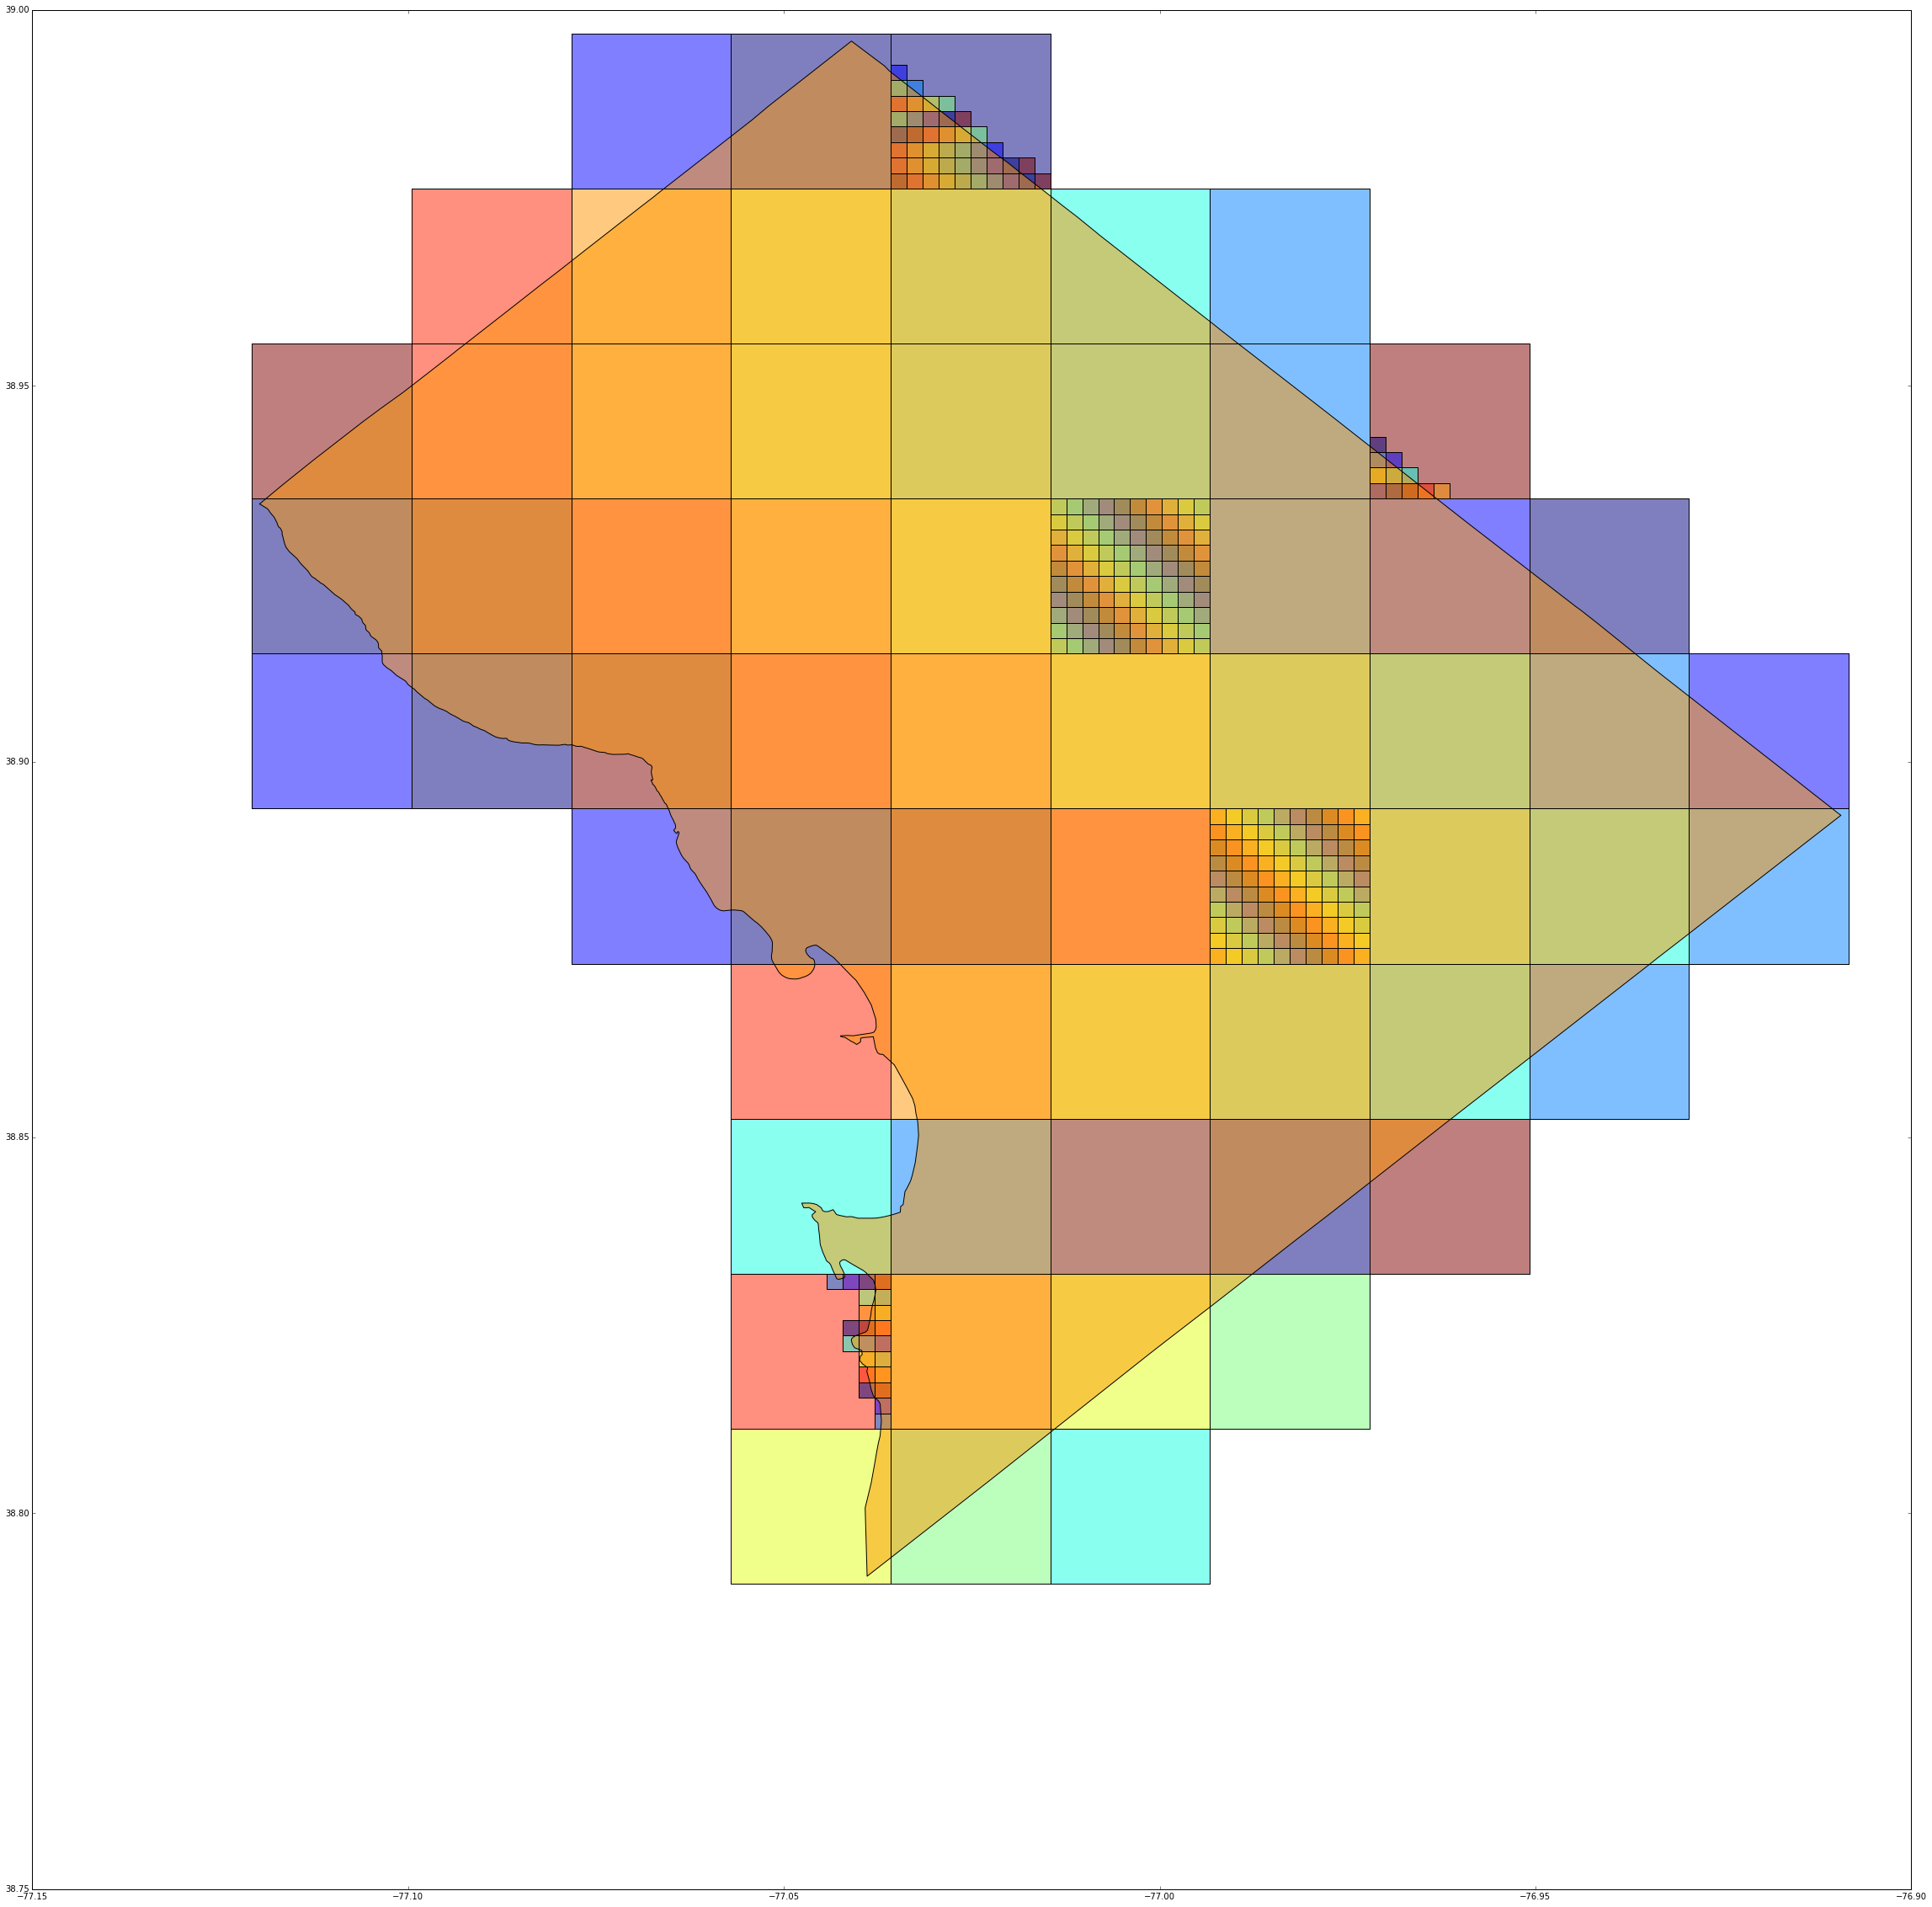

In [93]:
grids = grid_area(SW, NE, ngrid=10)
swnes = []
divided = 5
idxes = [0,13,46,65,77,94]
while len(grids)>0:
    sw, ne = grids.pop()
    swnepoly = swne2poly(sw,ne)
    if swnepoly.intersects(dc_poly):
        print len(grids)
        if len(grids)==idxes[divided]:
            divided-=1
            smaller_areas = grid_area(sw,ne)
            grids.extend(smaller_areas)
            print divided, len(grids)
        swnes.append(swnepoly)
        
gp.GeoDataFrame(swnes, columns=['geometry']).append(dc_poly_gpdf).plot(figsize=(40,40))

In [97]:
grid_area(SW, NE, ngrid=10)[4]

((38.79063104296462, -77.03580604355203),
 (38.811253098533854, -77.01456603736094))

In [121]:
grids = grid_area(*grid_area(SW, NE, ngrid=10)[65], ngrid=1)
request_cnt = 0
data_cach = []
while len(grids)>0:
    sw, ne = grids.pop()
    swnepoly = swne2poly(sw,ne)
    if swnepoly.intersects(dc_poly):
#         time.sleep(0.01)
        client = clients[request_cnt%len(clients)]
        search = client.venues.search(params={'intent': 'browse', 'sw':tu2str(sw), 'ne':tu2str(ne), 'limit':50})
        request_cnt += 1
        len_venues = search['venues'].__len__()
        data_cach.append('{}\t{}\t{}'.format((sw,ne),len_venues, search))
        if len_venues>=50:
            new_grids = grid_area(sw,ne)
            grids.extend(new_grids)
        if request_cnt%1000==0:
            print request_cnt
            with open(FRSQ_OUTPUT_PATH+'{}.txt'.format(request_cnt),'w') as f:
                f.write('\n'.join(data_cach))
            data_cach = []
if len(data_cach)>0:
    with open(FRSQ_OUTPUT_PATH+'{}.txt'.format(request_cnt),'w') as f:
        f.write('\n'.join(data_cach))
    data_cach = []

In [114]:
import foursquare
clients_id_secret = [
    ('B5UXLIK21H3XVVIIKBYVG55XXOAVF50OAEFYT5KNWEZ0AJFS', 'AZGHYGMVF3CPO0VUWQWIFP4DYBEIPUOLCT31SUKVTA3FOQRP'),
    ('VLX3BBUP4VTKT5BP53CBWMTKUWGVGBE34O52S4ULNWAAJURO','2534VD02WWGCJCILTTRJXXEOPLDTXDVREKXAKGX515HJV3H0'),
    ('VJR0HIRSW5AEWJL1U0YVP2CJNNY1DOMEBRBM3XD15MW55LQZ', 'MM55NWKDFC51M1PU2I3GNXDJQ0NNIDKNVBRNZJSW4COLBQIR'),
    ('CWCA2GY2YJKS4GTCBU4V3KI0KH2KMDVZXVJVKFS5C3VPXGCV', 'NLMSW00OFS2FZDYIEA5ZPM4RH35ZAHHFGQSTTC3BYGGX0OIS'),
    ('GOOWLBFKGWVYJA5E4ES5MUQCF5B2NWITHFNCCVUOLIIN3ZF3', 'UUZ32DS3U5CC22XJ5LIO3RVVMRWL4NFYOM2V3SZ0H1ETWKSC'),
    ('FJLWGSADBT2R1ELM0W14CIHSOSDZ0ZVGGKJOV5CUEC3JSUKM','0SA5RHLJ5LKRPPPAKQMLJVBB0HCWTQJ2LJD5OPO4LCO3H00L'),
    ('QUKQ3QQUXVAYNJOEYNOJIKLGGFPUTOQ2PWS4PNYJUTVY2UKB','BLCCAQAZYXFVLELFDYKJT4EOFLI3WGW4YKMDOIQ2XPFE3J3C'),
    ('I5QIF0SFJCRMAVBSBV3KEZSCQ02MLQZPJ2JPKIG2UFREDUXL','GQDNDG03NP4IXXM0QSIJUL3H3KMX0B2OWRNJRVQX3LH3FFOJ'),
    ('NRAQWNRMKH4W1BP3SQXTLJEKCQKXYOH1G0WPEBPFHVKEGZTM', 'BU2ST3EPY3MSUMKU1XLNTVV00XYBFDWCNWIVJNCWQ502OF11'),
]

clients = [foursquare.Foursquare(client_id=client_id, client_secret=client_secret) for client_id, client_secret in clients_id_secret]

In [79]:
import pandas as pd
pd.DataFrame(search['venues'])

,allowMenuUrlEdit,beenHere,categories,contact,delivery,hasMenu,hasPerk,id,location,menu,name,referralId,specials,stats,storeId,url,venueChains,venuePage,verified
0,True,"{u'unconfirmedCount': 0, u'marked': False, u'l...","[{u'pluralName': u'Breweries', u'primary': Tru...","{u'phone': u'3015579818', u'formattedPhone': u...",NaN,NaN,False,53a5a667498e60f10d71cb4f,"{u'city': u'Silver Spring', u'labeledLatLngs':...",NaN,Denizens Brewing Co.,v-1477969753,"{u'count': 0, u'items': []}","{u'tipCount': 18, u'checkinsCount': 1758, u'us...",NaN,http://denizensbrewingco.com,[],{u'id': u'96509352'},True
1,NaN,"{u'unconfirmedCount': 0, u'marked': False, u'l...","[{u'pluralName': u'Parks', u'primary': True, u...",{},NaN,NaN,False,4bb8cf463db7b71328a3219a,"{u'city': u'Silver Spring', u'labeledLatLngs':...",NaN,Jesup Blair Park,v-1477969753,"{u'count': 0, u'items': []}","{u'tipCount': 0, u'checkinsCount': 922, u'user...",NaN,NaN,[],NaN,False
2,True,"{u'unconfirmedCount': 0, u'marked': False, u'l...","[{u'pluralName': u'Buildings', u'primary': Tru...","{u'phone': u'3014959335', u'formattedPhone': u...",NaN,NaN,False,4b1ec394f964a5202a1f24e3,"{u'city': u'Silver Spring', u'labeledLatLngs':...",NaN,Mr Wash Car Wash,v-1477969753,"{u'count': 0, u'items': []}","{u'tipCount': 5, u'checkinsCount': 716, u'user...",NaN,NaN,[],NaN,False
3,True,"{u'unconfirmedCount': 0, u'marked': False, u'l...","[{u'pluralName': u'Performing Arts Venues', u'...","{u'phone': u'2405671300', u'twitter': u'montgo...",NaN,NaN,False,4b4253ecf964a520aad125e3,"{u'city': u'Silver Spring', u'labeledLatLngs':...",NaN,Montgomery College Cultural Arts Center,v-1477969753,"{u'count': 0, u'items': []}","{u'tipCount': 6, u'checkinsCount': 907, u'user...",NaN,http://www.montgomerycollege.edu,[],NaN,False
4,True,"{u'unconfirmedCount': 0, u'marked': False, u'l...","[{u'pluralName': u'Convenience Stores', u'prim...","{u'facebookName': u'7-Eleven', u'twitter': u'7...",NaN,NaN,False,4bb8f56fb35776b05b72c901,"{u'city': u'Silver Spring', u'labeledLatLngs':...",NaN,7-Eleven,v-1477969753,"{u'count': 0, u'items': []}","{u'tipCount': 5, u'checkinsCount': 1242, u'use...",32389,http://www.7-eleven.com,[{u'id': u'556f676fbd6a75a99038d8e9'}],NaN,True
5,NaN,"{u'unconfirmedCount': 0, u'marked': False, u'l...","[{u'pluralName': u'Community Colleges', u'prim...","{u'phone': u'2405671300', u'twitter': u'montgo...",NaN,NaN,False,4b9110fdf964a520f2a133e3,"{u'city': u'Takoma Park', u'labeledLatLngs': [...",NaN,Montgomery College | Takoma Park/Silver Spring,v-1477969753,"{u'count': 0, u'items': []}","{u'tipCount': 0, u'checkinsCount': 3362, u'use...",NaN,NaN,[],NaN,False
6,True,"{u'unconfirmedCount': 0, u'marked': False, u'l...","[{u'pluralName': u'Seafood Restaurants', u'pri...","{u'phone': u'3015891306', u'facebook': u'25559...",NaN,True,False,4baead07f964a520aacd3be3,"{u'city': u'Silver Spring', u'labeledLatLngs':...",{u'url': u'https://foursquare.com/v/crisfield-...,Crisfield Seafood,v-1477969753,"{u'count': 0, u'items': []}","{u'tipCount': 26, u'checkinsCount': 1090, u'us...",NaN,http://www.crisfieldseafood.com,[],NaN,False
7,True,"{u'unconfirmedCount': 0, u'marked': False, u'l...","[{u'pluralName': u'Ice Cream Shops', u'primary...","{u'facebookName': u'Moorenko's Ice Cream', u't...",NaN,True,False,4b75fb08f964a520fb332ee3,"{u'city': u'Silver Spring', u'labeledLatLngs':...",{u'url': u'https://foursquare.com/v/moorenkos-...,Moorenko's Ice Cream,v-1477969753,"{u'count': 0, u'items': []}","{u'tipCount': 14, u'checkinsCount': 1153, u'us...",,http://www.moorenkos.com,[],{u'id': u'37146262'},True
8,NaN,"{u'unconfirmedCount': 0, u'marked': False, u'l...","[{u'pluralName': u'Medical Schools', u'primary...","{u'phone': u'2405671300', u'twitter': u'montgo...",NaN,NaN,False,4cc9ee217965b60c8468828a,"{u'city': u'Silver Spring', u'labeledLatLngs':...",NaN,MC Health Sciences Center,v-1477969753,"{u'count': 0, u'items': []}","{u'tipCount': 0, u'checkinsCount': 619, u'user...",NaN,NaN,[],NaN,False
9,True,"{u'unconfirmedCou

In [55]:
def tu2str(tu):
    return ','.join([str(t) for t in tu])

In [138]:
from ast import literal_eval

(21482, 1)


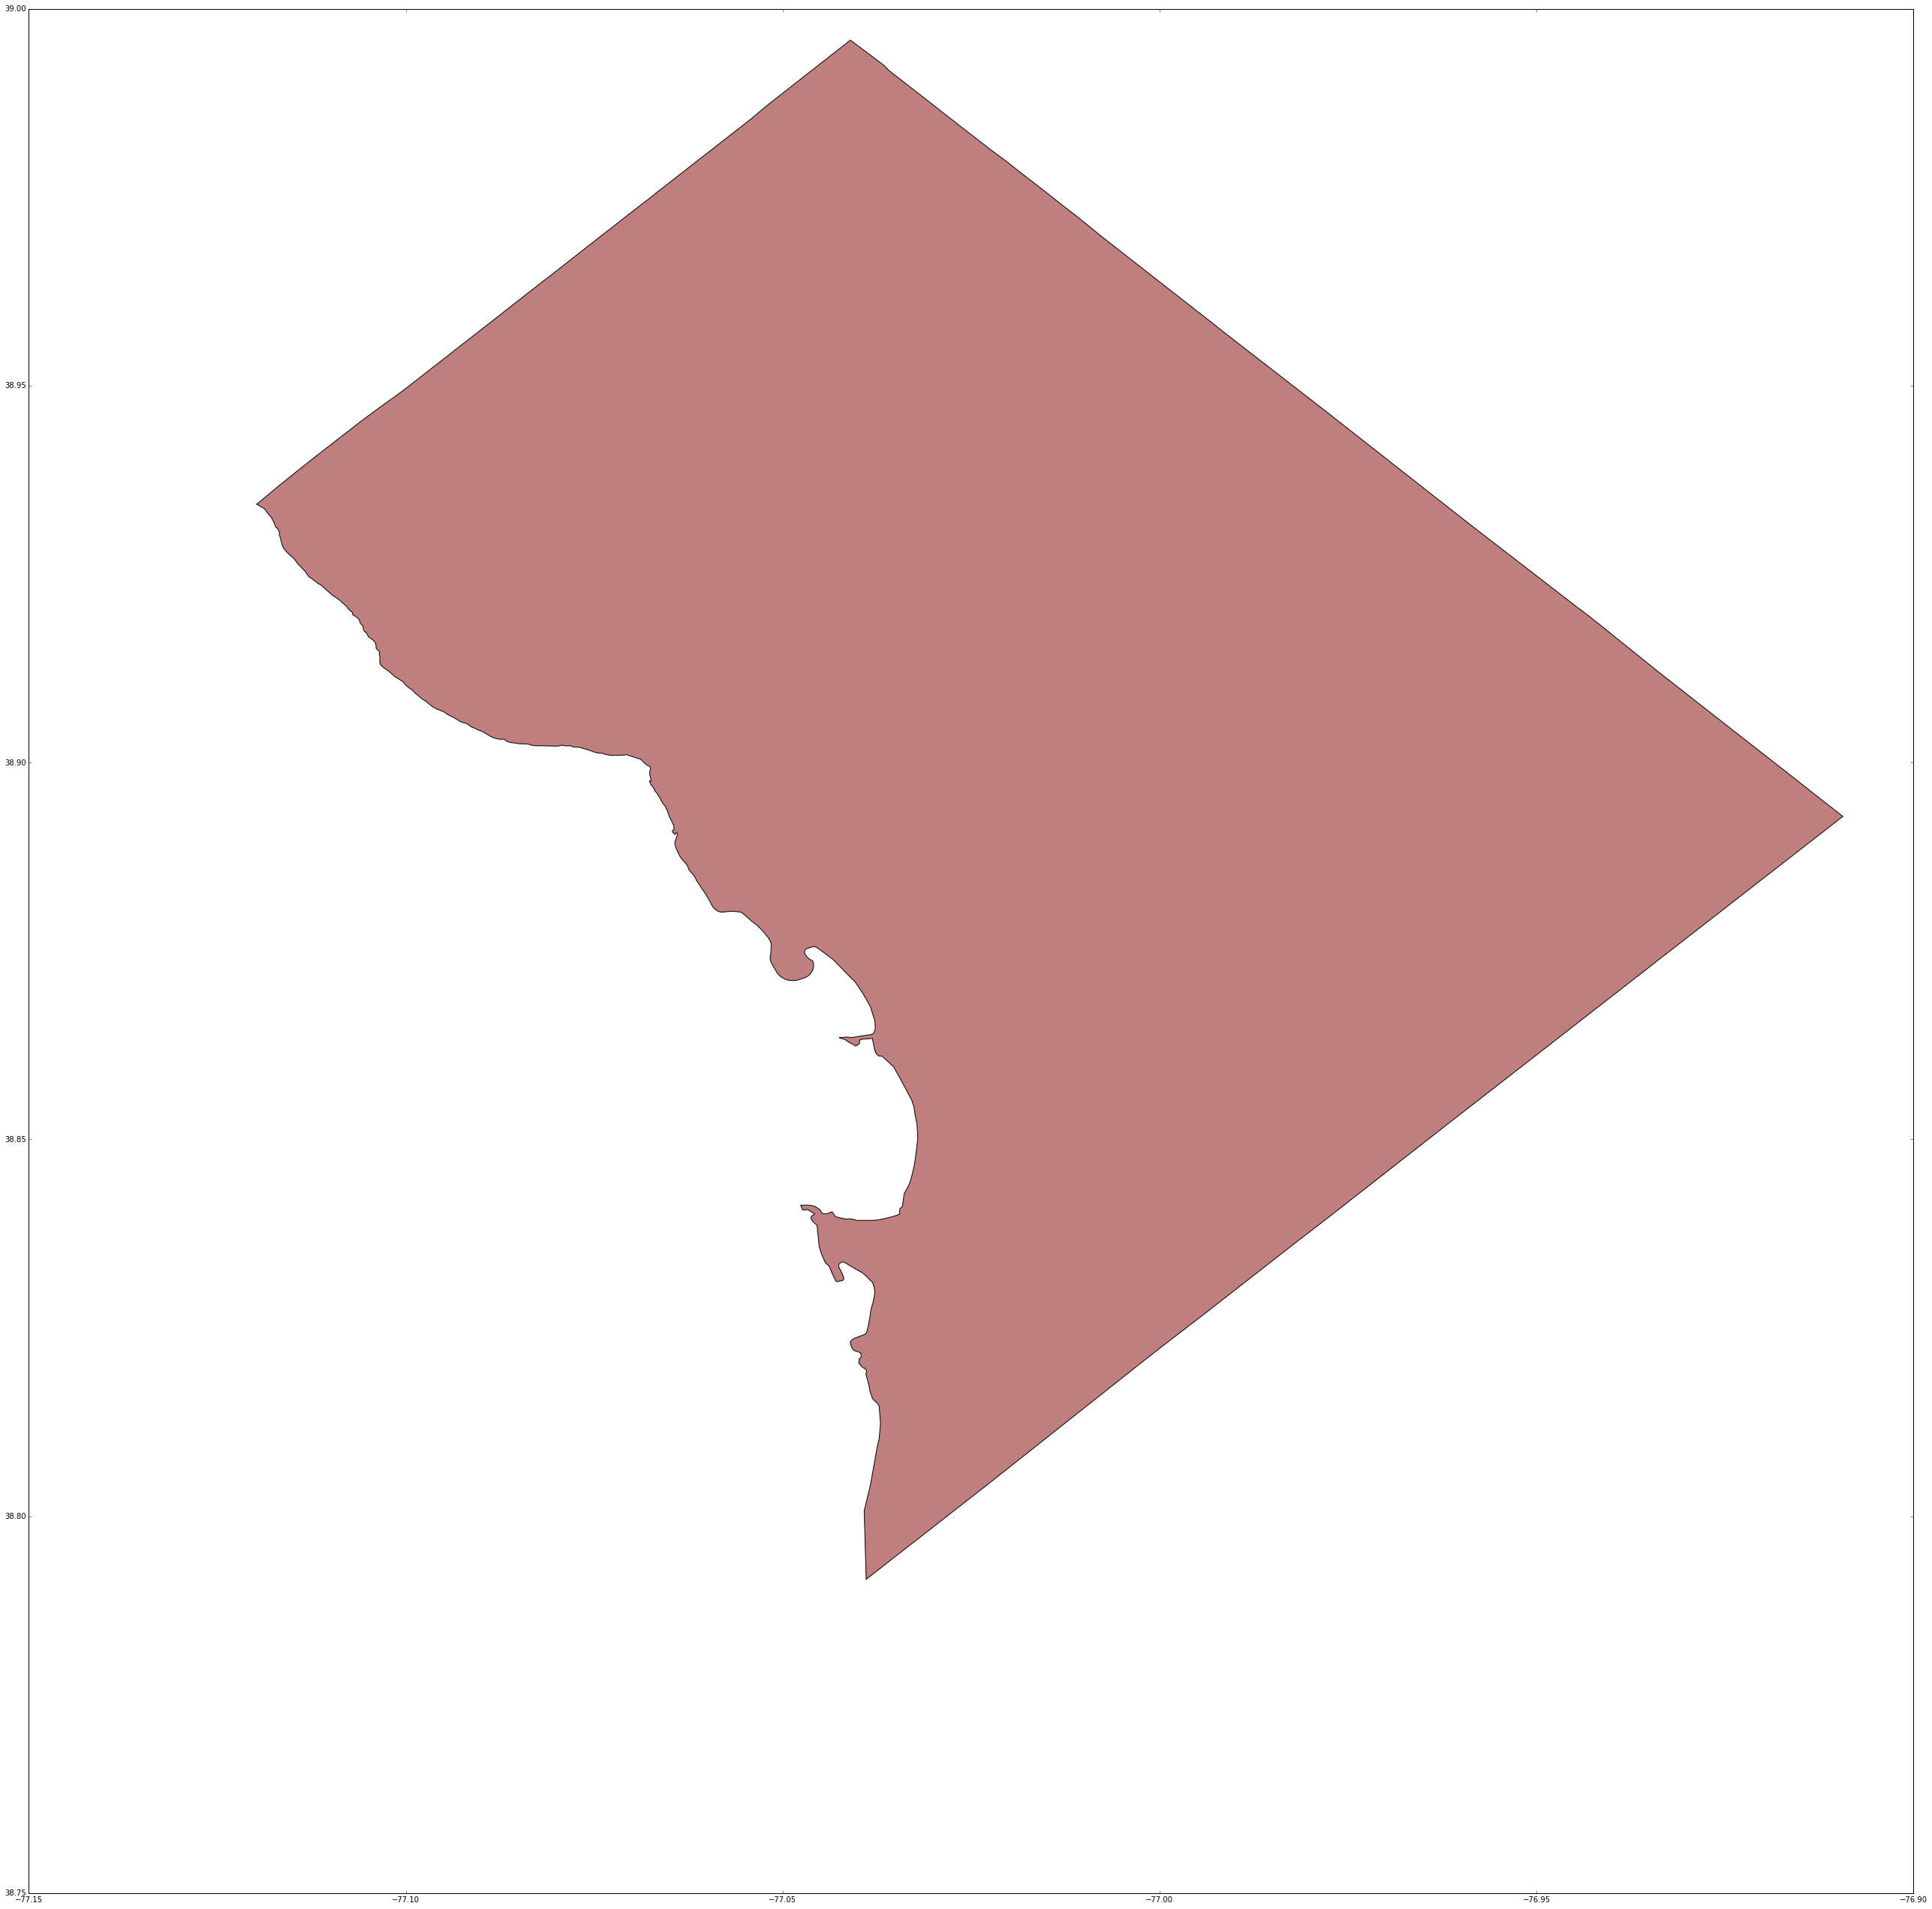

In [146]:
import glob
import csv
merge_df = gp.GeoDataFrame([dc_poly],columns=['geometry'])
merge_df.plot(figsize=(45,45))
for fn in glob.glob('data/output/4square/*'):
    with open(fn) as f:
        swne_polys = [swne2poly(*literal_eval(line.split('\t')[0])) for line in f]
    gpdf = gp.GeoDataFrame(swne_polys,columns=['geometry'])
    merge_df = merge_df.append(gpdf,ignore_index=True)
print merge_df.shape

In [24]:
import sys

# sys.path.insert(0, os.path.abspath('../../'))
from utils import geofunc
geofunc.grid_area

<function utils.geofunc.grid_area>

In [20]:
import os
os.path.abspath('../../')

'D:\\\xa1\xef\xa1\xef\xd1\xa7\xcf\xb0\xb9\xa4\xd7\xf7\\Life in Maryland\\Research Project\xa3\xbaCyclingSafe\\github'

In [21]:
import sys
sys.path

['D:\\\xa1\xef\xa1\xef\xd1\xa7\xcf\xb0\xb9\xa4\xd7\xf7\\Life in Maryland\\Research Project\xa3\xbaCyclingSafe\\github',
 'D:\\\xa1\xef\xa1\xef\xd1\xa7\xcf\xb0\xb9\xa4\xd7\xf7\\Life in Maryland\\Research Project\xa3\xbaCyclingSafe\\github\\Cycling_Safe',
 'D:\\\xa1\xef\xa1\xef\xd1\xa7\xcf\xb0\xb9\xa4\xd7\xf7\\Life in Maryland\\Research Project\xa3\xbaCyclingSafe\\github\\Cycling_Safe',
 'D:\\\xa1\xef\xa1\xef\xd1\xa7\xcf\xb0\xb9\xa4\xd7\xf7\\Life in Maryland\\Research Project\xa3\xbaCyclingSafe\\github\\Cycling_Safe',
 '',
 'D:\\Program Files\\Anaconda2\\lib\\site-packages\\pgmpy-0.1.0-py2.7.egg',
 'D:\\Program Files\\Anaconda2\\lib\\site-packages\\coveralls-1.1-py2.7.egg',
 'D:\\Program Files\\Anaconda2\\lib\\site-packages\\docopt-0.6.2-py2.7.egg',
 'D:\\Program Files\\Anaconda2\\lib\\site-packages\\coverage-4.1b2-py2.7-win-amd64.egg',
 'D:\\Program Files\\Anaconda2\\python27.zip',
 'D:\\Program Files\\Anaconda2\\DLLs',
 'D:\\Program Files\\Anaconda2\\lib',
 'D:\\Program Files\\Anaconda

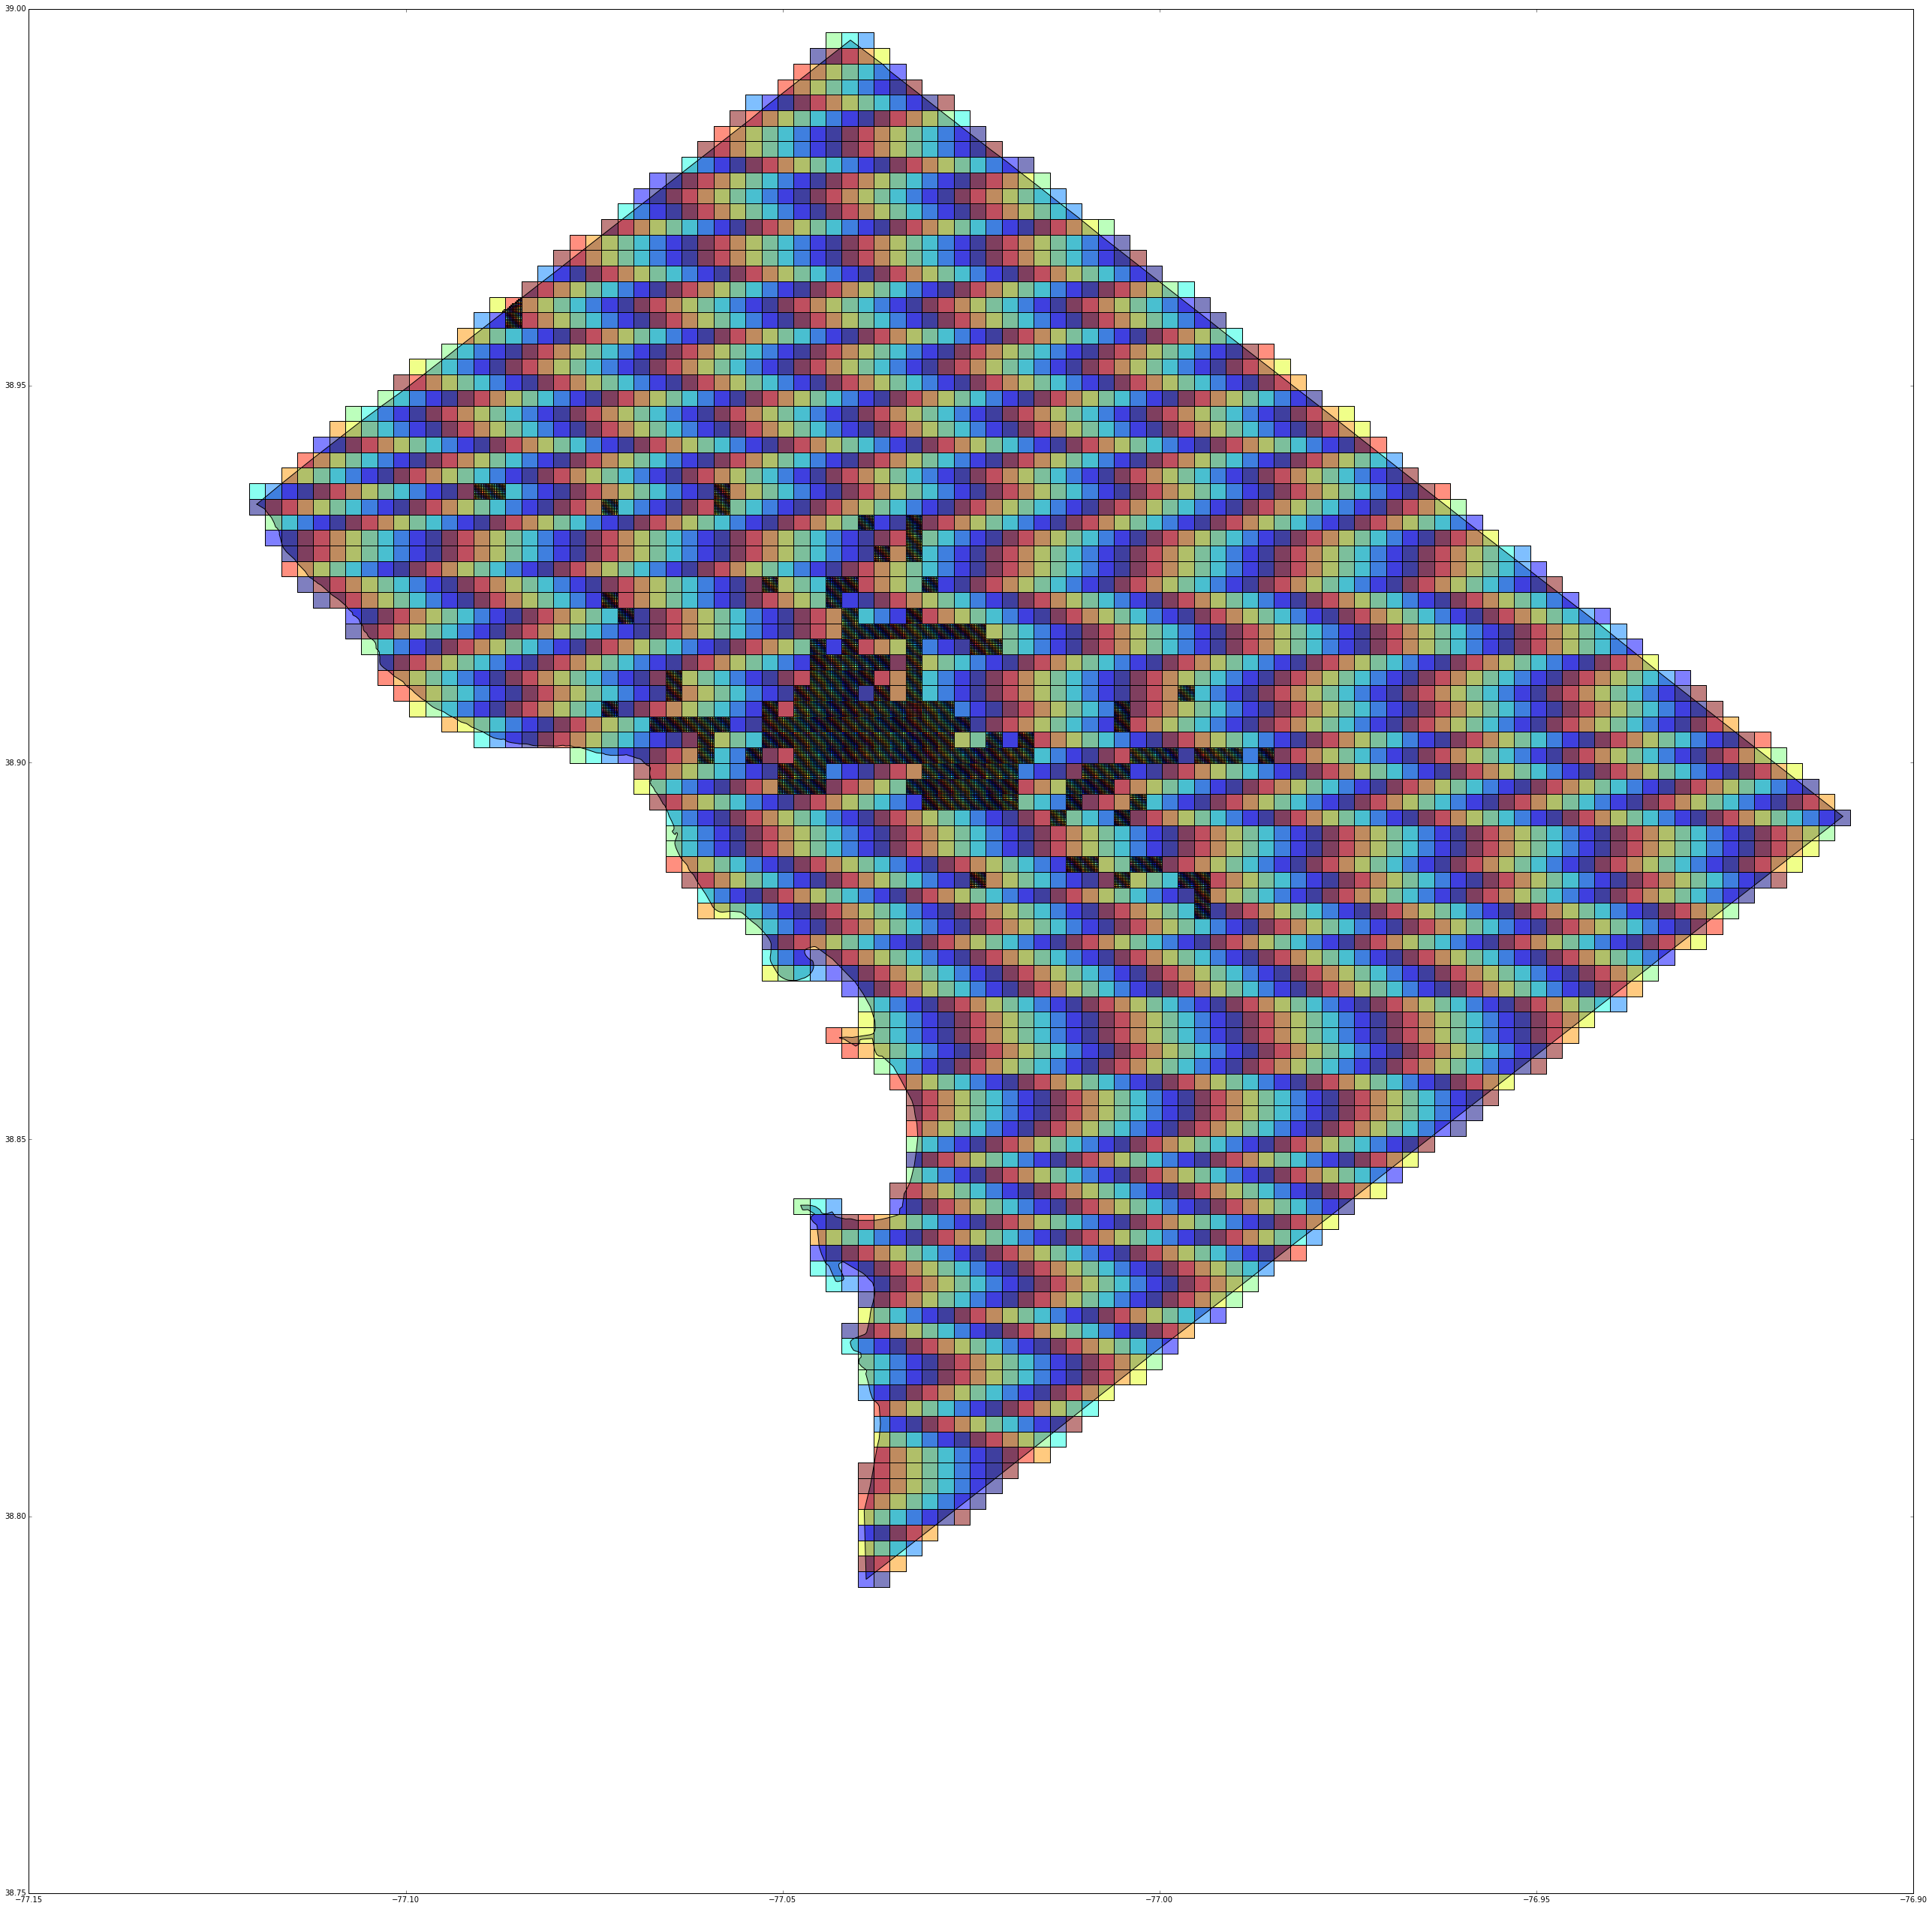

In [147]:
merge_df.plot(figsize=(45,45))